In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rfest.MF import semiNMF, KMeans
from rfest._splines import build_spline_matrix

## Simulated Subunits

In [2]:
def gaussian(dims, sigma, mu):
    
    import numpy as onp
    
    if len(dims) == 1:
        
        x = dims[0]
        xx = onp.arange(x)
        
        gaussian_filter = 1/(sigma*onp.sqrt(2*onp.pi))*onp.exp(-1*(xx-mu)**2/ (2*sigma**2) )
        gaussian_filter = gaussian_filter.reshape(*dims, 1)
        
    else:
        
        if 1 < len(dims) < 3:
        
            x = dims[0]
            y = dims[1]
            
        elif len(dims) > 2:
            
            y = dims[1]
            x = dims[2]
        
        sigx = sigma[0]
        sigy = sigma[1]
        
        mux = mu[0]
        muy = mu[1]
        
        xx, yy = onp.meshgrid(onp.arange(0, y), onp.arange(0, x))
        
        gaussian_window = onp.exp(-0.5 * (((xx - mux) / sigx)**2 + ((yy - muy) / sigy)**2))
        gaussian_filter = 0.5 * gaussian_window / (0.5 * onp.pi * (sigx + sigy) ** 2)
        gaussian_filter = 0.25 * gaussian_filter / gaussian_filter.max()
        gaussian_filter = gaussian_filter.T
    
    return gaussian_filter.T

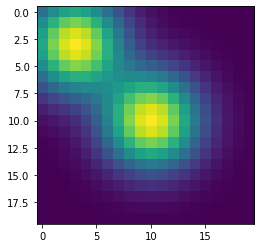

In [3]:
dims = [20, 20]

k0 = gaussian(dims, [3,3], [10, 10])
k1 = gaussian(dims, [3,3], [3, 3])

plt.imshow(k0+k1)

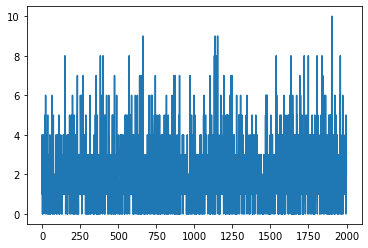

In [4]:
def nonlin(x):
    return np.log(1+np.exp(x))+1e-7

dt = 1
n = np.prod(dims) * 5
X = np.random.randn(n, *dims).reshape(n, np.prod(dims))

ci = nonlin(X @ k0.flatten()) + nonlin(X @ k1.flatten())
y = np.random.poisson(nonlin(ci) * dt)

plt.plot(y)

## Kmeans

In [5]:
V = X[y!=0]

In [6]:
kms = KMeans(V.T, 2, build_S=True, dims=dims, df=7)

In [8]:
kms.fit(num_iters=1000, verbal=1)

Iter	Cost
0	1.085
1	0.997
2	0.997
3	0.997
4	0.997
5	0.997
6	0.996
7	0.996
8	0.996
9	0.996
10	0.996
11	0.996
12	0.996
13	0.996
14	0.996
15	0.996
16	0.996
17	0.996
18	0.996
19	0.996
20	0.996
21	0.996
22	0.996
23	0.996
24	0.996
25	0.996
26	0.996
27	0.996
28	0.996
29	0.996
30	0.996
31	0.996
32	0.996
33	0.996
34	0.996
35	0.996
36	0.996
37	0.996
38	0.996
39	0.996
40	0.996
41	0.996
42	0.996
43	0.996
44	0.996
45	0.996
46	0.996
47	0.996
48	0.996
49	0.996
50	0.996
51	0.996
52	0.996
Stop: cost has been changing so small in the last ten chechpoint. Final cost = 0.996


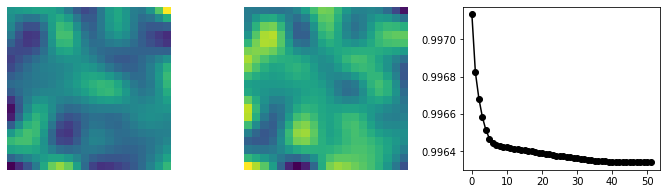

In [13]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
for i in range(2):
    ax[i].imshow(kms.W[:, i].reshape(dims))
    ax[i].axis('off')
    
ax[2].plot(kms.cost[1:], 'ko-')

## semiNMF

In [10]:
nmf = semiNMF(V.T, k=2, build_L=True, dims_L=dims, df_L=7)

Initializing with `kmeans`...
Finished initialization.


In [11]:
nmf.fit(num_iters=3000, verbal=1)

Iter	Cost
0	0.996
1	0.996
2	0.996
3	0.995
4	0.995
5	0.995
6	0.995
7	0.995
8	0.995
9	0.995
10	0.995
11	0.995
12	0.995
13	0.995
14	0.995
15	0.995
16	0.995
17	0.995
18	0.995
19	0.995
20	0.995
21	0.995
22	0.995
23	0.995
24	0.995
25	0.995
26	0.995
27	0.995
28	0.995
29	0.995
30	0.995
31	0.995
32	0.995
33	0.995
34	0.995
35	0.995
36	0.995
37	0.995
38	0.995
39	0.995
40	0.995
41	0.995
42	0.995
43	0.995
44	0.995
45	0.995
46	0.995
47	0.995
48	0.995
49	0.995
50	0.995
51	0.995
52	0.995
53	0.995
54	0.995
55	0.995
56	0.995
57	0.995
58	0.995
59	0.995
60	0.995
61	0.995
62	0.995
63	0.995
64	0.995
65	0.995
66	0.995
67	0.995
68	0.995
69	0.995
70	0.995
71	0.995
72	0.995
73	0.995
74	0.995
75	0.995
76	0.995
77	0.995
78	0.995
79	0.995
80	0.995
81	0.995
82	0.995
83	0.995
84	0.995
85	0.995
86	0.995
87	0.995
88	0.995
89	0.995
90	0.995
91	0.995
92	0.995
93	0.995
94	0.995
95	0.995
96	0.995
97	0.995
98	0.995
99	0.995
100	0.995
101	0.995
102	0.995
103	0.995
104	0.995
105	0.995
106	0.995
107	0.995
108	0.995
109	0.995


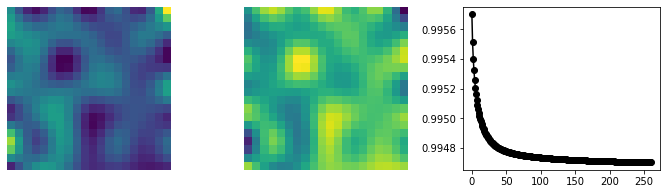

In [16]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
for i in range(2):
    ax[i].imshow(nmf.W[:, i].reshape(dims))
    ax[i].axis('off')
    
ax[2].plot(nmf.cost[1:], 'ko-')